In [29]:
#from torchcontrib.optim import SWA
#!pip install pytorch-lightning==1.3

import pytorch_lightning as pl
import torchvision
import comet_ml


import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence

from torch.optim import Adam, Adamax, SGD, AdamW
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler

from torchmetrics import R2Score, Pearson

#import torchvision.transforms as transforms

In [13]:
#sgd_adam_best_model-v10.ckpt is the best so far
!ls -lh checkpoints/

total 19G
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 11 01:31  best_model.chpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 11 16:26  best-model-new-life.ckpt.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 11 11:30  best-model-new-life.ckpt-v1.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 11 21:01  best-model-new-life.ckpt-v2.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 12 09:34  best-model-new-life-validation-0.3.ckpt.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 11 23:34  best-model-new-life-validation-0.3.ckpt-v1.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 12 11:20  best-model-new-life-validation-0.3.ckpt-v2.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 13 07:43  best_model_so_far_nighty_nighty.ckpt
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul 13 01:08  best_model_so_far-v1.ckpt
drwxr-xr-x. 2 sharapov ml4rg2022 4.0K Jul 10 23:09  checkpoints
-rw-r--r--. 1 sharapov ml4rg2022 993M Jul  8 21:54 'epoch=0-val_loss=0.00-new_architecture.ckpt'
-rw-r--r--. 1 sharapov ml4rg2022  61M Jul  8 

In [2]:
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging, ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [3]:
import pandas as pd
import numpy as np

from copy import deepcopy

from tqdm import tqdm 
#from google.colab import drive

from joblib import effective_n_jobs

from itertools import chain

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from typing import Dict, Tuple, Optional, List

from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
def create_raw_numpy(filedir: str=".", 
                     max_length: int=142,
                     eps: float=0.15,
                     size=-1) -> np.ndarray:

    nuc_map = {k: i for i, k in enumerate(['A', 'C', 'T', 'G', 'N'])}
    sample_weights = {k: 0 for k in range(20)}

    full_size = 6739258 if size == -1 else size

    x = np.empty((full_size, max_length - 17 - 13, 4), np.float16)
    gc_content = np.empty(full_size, np.float16)
    y = np.empty(full_size, np.float16)

    try:

        with open(f'{filedir}/train_sequences.txt', 'r') as f:
            with tqdm(total=full_size, position=0, leave=True) as prog_bar:
                for i, line in enumerate(tqdm(f.readlines(), position=0, leave=True)):
                    seq, expr = line.split('\t')
                    #seq = remove_suffix(remove_prefix(seq, PREFIX), SUFFIX)

                    #print(seq)
                    nuc_idx = np.array([nuc_map[s] for s in seq[17: -13]], dtype=int)
                    pos_idx = np.arange(nuc_idx.size)[nuc_idx != 4]
                    nuc_idx = nuc_idx[nuc_idx != 4]

                    one_hot = np.zeros((max_length - 17 - 13, 4))
                    one_hot[pos_idx, nuc_idx] = 1 / (max_length - 17 - 13)

                    #print(one_hot.shape, x.shape)

                    x[i,...] = one_hot
                    y[i] = float(expr) + np.random.uniform(0, eps)

                    gc_content[i] = x[i][np.isin(np.argmax(x[i], 1), np.array([1, 2]))].sum() / x[i].shape[0]
                    #print(gc_content)

                    sample_weights[round(y[i])] += 1

                    prog_bar.update()

    except:

        return x, gc_content, y

    return x, gc_content, y


def get_weights(y: np.ndarray, w: Optional[pd.Series]=None) -> Tuple[np.ndarray]:

    y = pd.DataFrame(y.numpy())
    
    w = 1. / (y.round().value_counts())
    weights = w / w.sum()
    
    #print(weights)
    
    weights = weights.to_frame()

    y["rounded"] = y.apply(round)
    y = pd.merge(
      left=y,
      right=weights,
      left_on="rounded",
      right_index=True,
    )

    return y["0_y"].values


    #np.savez('data/one_hot', x=x, y=y)

In [5]:
x, gc_content, y = create_raw_numpy()

100%|██████████| 6739258/6739258 [06:17<00:00, 17861.11it/s]


In [23]:
x_, gc_content, y_ = x[:5000000], gc_content[:5000000], y[:5000000]

In [7]:
y_plug = y + 0.4 * np.random.randn(len(y))

In [102]:
split_ratio = .8 
torch.set_default_dtype(torch.double)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#transformations =  transforms.Compose(
#    [transforms.Normalize()]
#)

hparams = {
    "dataset":
    {
        "train":
        {
            "transforms": None,
            "batch_size": 1024, #256, 
            "root_dir": "/content/drive/MyDrive/genomics",
            "max_length": 142,
            "filename": "train_sequences.txt",
        },
        "test":
        {
            "transforms": None,
            "batch_size": 1024, #256, 
            "root_dir": "/content/drive/MyDrive/genomics",
            "max_length": 142,
            "filename": "test_sequences.txt"
        }
    },
    "model":
    {
        "training": {
            "init_lr": 1e-4,
            "min_lr": 1e-6,
            "reduce_on_plateau_patience": 1,
            "factor": 0.5,
            "weight_decay": 1e-3,
        },
    "backbone":{
        "channels": [1, 32, 16],
        "depths": [1, 1],
        "p": [None, None],
        "use_pooling": [True, True, True],
        "kernel_sizes": [(3, 1), (3, 1)],
        "strides": [(1, 1), (1, 1)],
        "scaling_factor": [2, "full"],
        "apply_softmax": [False, False],
    },
    "head":{
        "residualize": [False],
        "dims": [16, 1],
    }
}
}

In [76]:
#best
    "backbone":{
        "channels": [1, 256, 512],
        "depths": [1, 1],
        "p": [None, 0.5],
        "use_pooling": [False, True],
        "kernel_sizes": [(13, 1), (5, 1)],
        "strides": [(1, 1), (1, 1)],
        "scaling_factor": [3, 3],
        "apply_softmax": [True, False],
    },
    "head":{
        "residualize": [False],
        "dims": [800, 1],
    }


IndentationError: unexpected indent (83970994.py, line 2)

In [77]:
#Deeper model
hparams["model"]["backbone"]["kernel_sizes"] = [(11, 1), (5, 1), (3, 1)]
hparams["model"]["backbone"]["strides"] = [(1, 1), (1, 1), (1, 1)]
hparams["model"]["backbone"]["scaling_factor"] = [3, 3, 3]
hparams["model"]["backbone"]["p"] = [False, 0.5, 0.5]
hparams["model"]["backbone"]["channels"] = [1, 512, 512, 512]
hparams["model"]["backbone"]["depths"] = [1, 1, 1]
hparams["model"]["backbone"]["apply_softmax"] = [True, False, False]

hparams["model"]["head"]["dims"] = [1 * 8 * 256, 32, 1]

hparams["model"]["training"]["weight_decay"] = 1e-4

In [67]:
class TensorDatasetWithTransforms(Dataset):
    
    def __init__(self, dataset: TensorDataset, transforms=None) -> None:
        
        self.dataset = dataset
        self.transforms = transforms
        
    def __len__(self) -> int:
        
        return len(self.dataset)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Optional[torch.Tensor], torch.Tensor]:
        
        X, y = self.dataset[idx]
        
        gc_content = X[torch.isin(torch.argmax(X, 1), torch.tensor([1, 2]))].sum() / X.shape[0]
        
        return X, gc_content, y
        #if self.transforms:
        #    X = 

In [69]:
x_train, x_val, gc_train, gc_val, y_train, y_val = train_test_split(x, y, y, test_size=.2)
dataset_train, dataset_val = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), \
                             TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))

In [103]:
w_train = get_weights(dataset_train.tensors[-1])


weighted_sampler = WeightedRandomSampler(weights=torch.from_numpy(w_train[:-1]).double(), 
                                         num_samples=len(w_train))

dataloader_train = DataLoader(dataset_train, 
                              batch_size=hparams["dataset"]["train"]["batch_size"],
                              sampler=weighted_sampler,
                              drop_last=True,
                              num_workers=16,
                              shuffle=False,
                              )
dataloader_val = DataLoader(dataset_val, 
                            batch_size=hparams["dataset"]["train"]["batch_size"],
                            )

In [80]:

dataloaders = {

    "train": dataloader_train,
    "val": dataloader_val,
    
}

In [104]:
class SimpleConvBlock(nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: Tuple[int], 
               strides: List[Tuple], depth: int, scaling_factor: int, p: Optional[float]=None,
               apply_softmax: bool=False
              ) -> None:

    super().__init__()

    
    self.scaling_factor = scaling_factor
    self.apply_softmax = apply_softmax

    self.layers = [
                [
                  nn.Conv2d(in_channels if d == 0 else out_channels, out_channels, kernel_size, strides[d], 0, bias=True), 
                  nn.BatchNorm2d(out_channels),
                  nn.PReLU(1), #out_channels),
                  nn.Dropout2d(p) if p else nn.Identity()
                  ]   
                for d in range(depth)
    ]# + [[nn.AdaptiveMaxPool2d()]]

    self.layers = list(chain.from_iterable(self.layers))

    self.block = nn.Sequential(
        *self.layers
    )
    
    self.weights_custom = nn.Parameter(data=torch.empty((out_channels, in_channels, kernel_size[0], kernel_size[1])))
    nn.init.kaiming_normal_(self.weights_custom)

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    #x = F.conv2d(x, F.softmax(self.weights_custom, 3), bias=None)
    x = self.block(x)
    
    x = F.softmax(x, dim=3) if self.apply_softmax else x
    
    #if self.residualize:
    #    x += y
    
    if isinstance(self.scaling_factor, int):
        x = F.adaptive_max_pool2d(x, x.size(2) // self.scaling_factor)
    elif self.scaling_factor == "full":
        x = F.adaptive_max_pool2d(x, 1)
    else:
        x = x
    
    #print(x.shape)

    return x

class Residualize(nn.Module):

  def __init__(self, module: nn.Module) -> None:

    super().__init__()

    self.module = module

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    
    Y = self.module(X)
    
    X = X + Y

    return X
    


In [105]:
class SimpleConvNet(pl.LightningModule):

  def __init__(self, threshold: Tuple[float, float, bool], **hparams) -> None:

    super().__init__()

    self.save_hyperparameters()
    self.automatic_optimization = True #False
    self.default_dtype = torch.float16

    self.learning_rate = self.hparams["model"]["training"]["init_lr"]

    self.layers = [
                
              SimpleConvBlock(
                  self.hparams["model"]["backbone"]["channels"][i], 
                  self.hparams["model"]["backbone"]["channels"][i + 1],
                  self.hparams["model"]["backbone"]["kernel_sizes"][i],
                  self.hparams["model"]["backbone"]["strides"][i],
                  self.hparams["model"]["backbone"]["depths"][i],
                  self.hparams["model"]["backbone"]["scaling_factor"][i],
                  self.hparams["model"]["backbone"]["p"][i] if self.hparams["model"]["backbone"]["p"] else None,
                  self.hparams["model"]["backbone"]["apply_softmax"],
                  #self.hparams["model"]["backbone"]["paddings"][i]
              )
          for i in range(len(self.hparams["model"]["backbone"]["channels"]) - 1)

    ]

    self.backbone = nn.Sequential(*self.layers)

    self.head = nn.Sequential(
        *list(chain.from_iterable(
            [
             [
              Residualize(nn.Linear(self.hparams["model"]["head"]["dims"][d], self.hparams["model"]["head"]["dims"][d + 1])) if self.hparams["model"]["head"]["residualize"][d] \
              else nn.Linear(self.hparams["model"]["head"]["dims"][d], self.hparams["model"]["head"]["dims"][d + 1]),
              nn.BatchNorm1d(self.hparams["model"]["head"]["dims"][d + 1]) if d < len(self.hparams["model"]["head"]["dims"]) - 2 else nn.Identity(),
              nn.PReLU(num_parameters=1) if d < len(self.hparams["model"]["head"]["dims"]) - 2 else nn.Identity() #self.hparams["head"]["dims"][d + 1]),
              ]
             for d in range(len(self.hparams["model"]["head"]["dims"]) - 1)]
             + [[ nn.Softplus() ]]
        ))
    )


    #self.model = nn.Sequential(
    #    self.backbone,
    #    self.head,
    #)

    self.loss = nn.MSELoss()

  def log_dist(self, y: torch.Tensor, y_hat: torch.Tensor) -> None:
    
    y = y.squeeze()

    sns.kdeplot(y)
    sns.kdeplot(y_hat)

    self.logger.log_figure(figure=sns.get_figure())

  @torch.no_grad()
  def metric(self, y: torch.Tensor, y_hat: torch.Tensor) -> float:

    metric = r2_score(y.cpu().detach(), y_hat.cpu().detach())

    return metric

  def loss_func(self, y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:

    return self.loss(y_hat, y)

  def configure_optimizers(self):

    #optimizer = Adam([{"params": self.model.parameters(), "lr": self.hparams["model"]["training"]["init_lr"]}],
    #                 lr=self.learning_rate,#self.hparams["training"]["init_lr"],
    #                 weight_decay=self.hparams["model"]["training"]["weight_decay"])
    optimizer = AdamW([
                      {"params": self.backbone.parameters()},
                      {"params": self.head.parameters()},
                      ],
                     lr=self.learning_rate, #self.hparams["training"]["init_lr"],
                     weight_decay=self.hparams["model"]["training"]["weight_decay"],
                     amsgrad=True,
    )
                        
    lr_scheduler_1 = ReduceLROnPlateau(optimizer, 
                                     mode="min", 
                                     min_lr=self.learning_rate,#self.hparams["model"]["training"]["min_lr"],
                                     factor=self.hparams["model"]["training"]["factor"],
                                     patience=self.hparams["model"]["training"]["reduce_on_plateau_patience"],
                                     threshold=1e-3,
                                     )
    #lr_scheduler_2 = CosineAnnealingLR(optimizer,
    #                                   T_max=5,
    #                                   eta_min=1e-5)
    
    #return [optimizer], [lr_scheduler_1, lr_scheduler_2]
    return {
        "optimizer": optimizer,
        "scheduler": lr_scheduler_1,
        "monitor": "loss_train",
    }

  def forward(self, X: torch.Tensor) -> torch.Tensor:

    h = self.backbone(X).flatten(1)
    #h = torch.cat((h, features), dim=1)
    y_hat = self.head(h)
    
    return y_hat

  def _general_step(self, batch: Dict[str, torch.Tensor]) -> torch.Tensor:

    X, y = batch
    #X, y = batch["X"], batch["y"]
    X, y = X.double(), y.double()
    #X = F.dropout(X, 0.2)

    left, right, inside = self.hparams["threshold"]

    #print(y.sum())

    if inside:
      y[(y < left) | (y > right)] = 0
    else:
      y[(y >= left) & (y <= right)] = 0

    #y += 0.05 * torch.randn_like(y)
    #print(y.sum())
    
    if len(X.size()) < 4:
      X = X.unsqueeze(1)

    #X = (X - X.mean()) / X.var()

    y_hat = self.forward(X)
    
    loss = self.loss_func(y, y_hat.squeeze(1))
    metric = self.metric(y, y_hat.squeeze(1))

    return loss, metric

  def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor: #Dict[str, torch.Tensor]:

    optimizer, lr_schedulers = self.optimizers(), self.lr_schedulers()

    #optimizer.zero_grad()

    loss, metric = self._general_step(batch)
    #self.manual_backward(loss)

    #optimizer.step()

    #if (batch_idx + 1) % self.hparams["training"]"] == 0:
    #lr_schedulers[1].step(loss)

    #grad_norm = self.trainer.callback_metrics
    self.log("training loss", loss.detach().cpu().item(), prog_bar=True)
    self.log("training r2", metric, prog_bar=True)


    #return {
    #    "loss-train": loss
    #}

    log = {
        "training_loss": loss.detach().cpu().item(),
        "training_r2": metric,
    }

    return {"loss": loss, "metric": metric, "log": log}


  def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor: #Dict[str, torch.Tensor]:

    loss, metric = self._general_step(batch)

    self.log("validation loss", loss.detach().cpu().item(), prog_bar=True)
    self.log("validation metric", metric, prog_bar=True)

    log = {
        "val_loss": loss.detach().cpu().item(),
        "val_r2": metric,
    }

    return {"loss": loss, "metric": metric, "log": log}

  def training_epoch_end(self, training_step_outputs) -> torch.Tensor:

    optimizer = self.optimizers()

    loss_epoch = torch.tensor([output["loss"] for output in training_step_outputs])
    loss_mean = loss_epoch.mean()

  #def train_dataloader(self):

  #  dataset_train = SeqDataset(**self.hparams["dataset"]["train"])
  #  dataloader_train = DataLoader(dataset_train, batch_size=self.hparams["dataset"]["train"]["batch_size"])

  #  return dataloader_train
    #print(self.trainer.train_dataloaders)
    #idx = np.random.randint(len(self.trainer.train_dataloaders))
    #training_sample = self.trainer.train_dataloaders[idx]

    #print(optimizer.param_groups[0]['lr'])


  #  return loss_mean

  #def validation_epoch_end(self, validation_step_outputs) -> torch.Tensor:

  #  loss_epoch = torch.cat(validation_step_outputs)
  #  loss_mean = loss_epoch.mean()

  #  return loss_mean


In [106]:
model_inside = SimpleConvNet((0, 20, True), **hparams)

In [50]:
#sgd_adam_best_model-v8.ckpt
model_inside = SimpleConvNet.load_from_checkpoint("checkpoints/sgd_adam_best_model-v10.ckpt")

In [63]:
experiment = comet_ml.Experiment(
    api_key="ilhZ5PMVM28bCHxtbwUQOU2r0",
    project_name="general",
)

comet_logger = CometLogger(
    api_key="ilhZ5PMVM28bCHxtbwUQOU2r0",
    rest_api_key=comet_ml.get_config("comet.api_key"),
    project_name="dream",
    workspace="vamdemon",
    #optimizer_data=comet_ml.parameters,
)


trainer = Trainer(
    max_epochs=500,
    #deterministic=True,
    accelerator="gpu",
    gpus=1,
    track_grad_norm="inf",
    logger=comet_logger,
    gradient_clip_val=1,
    auto_lr_find=True,
    log_every_n_steps=1,
    callbacks=[
        StochasticWeightAveraging(
            swa_epoch_start=0.8,
            annealing_epochs=5,
            annealing_strategy="cos",
        ),
        ModelCheckpoint(
            dirpath="checkpoints/",
            filename="new_life_models"
        )
    ]
    #callbacks=EarlyStopping(monitor="loss_val", patience=5, mode="min"),
)

#trainer.tune(model)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: tensorboard, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/vamdemon/dream/6ac6ee6da5fb4f14978205515b9f82a8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     grad_inf_norm/backbone.0.block.0.bias_step         : 0.0
COMET INFO:     grad_inf_norm/backbone.0.block.0.weight_step [850] : (0.1095, 6.2394)
COMET INFO:     grad_inf_norm/backbone.0.block.1.bias_step [850]   : (0.0271, 1.6793)
COMET INFO:     grad_inf_norm/backbone.0.block.1.weight_step [850] : (0.0305, 2.5251)
COMET INFO:     grad_inf_norm/backbone.0.block.2.weight_step [850] : (0.0004, 2.4474)
COMET

In [ ]:
trainer.fit(
    model=model_inside,
    train_dataloaders=dataloaders["train"],
    val_dataloaders=dataloaders["val"],
)

/data/ouga/home/ag_gagneur/sharapov/.conda/envs/sharapov_genomics_env/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /data/nasif12/home_if12/sharapov/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/data/ouga/home/ag_gagneur/sharapov/.conda/envs/sharapov_genomics_env/lib/python3.9/site-packages/pytorch_lightning/core/optimizer.py:380: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 3.4 K 
1 | head     | Sequential | 17    
2 | loss     | MSELoss    | 0     
----------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)
COMET WARNING: Set model graph 

Sanity Checking: 0it [00:00, ?it/s]

/data/ouga/home/ag_gagneur/sharapov/.conda/envs/sharapov_genomics_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 92it [00:00, ?it/s]

In [19]:
class AttentionSeq(nn.Module):
    
    def __init__(self, **hparams):
        
        super().__init__()
        

ERROR! Session/line number was not unique in database. History logging moved to new session 78


In [60]:
torch.cuda.empty_cache()

In [85]:
it = iter(dataloaders["val"])
next(it)
batch = next(it)
X, features, y = batch

In [ ]:
model_inside

In [ ]:
torch.cuda.is_av

In [54]:
#dataset_from = dataset_train
X_, features, y_ = dataset_val.tensors

with torch.no_grad():

    #sample = samples[1]

    #X, y = sample['X'], sample['y']
    y_hats = []
    ys = []
    
    model_inside = model_inside.cuda()
    model_inside.eval()
    
    with tqdm(total=len(dataset_val) // 10, position=0, leave=True) as prog_bar:
        for X, _, __ in tqdm(dataset_val, position=0, leave=True):

            X = X.unsqueeze(0) if len(X.size()) < 4 else X
            X = X.to(dtype=torch.double).to(device="cuda:0")

            features = features.unsqueeze(1) if len(features.size()) < 4 else X
            features = features.to(dtype=torch.double).to(device="cpu")

            #print(next(model_inside.model.parameters()).device)
            
            #print(X.unsqueeze(1).size())
            
            #print(model_inside.backbone(X.unsqueeze(1)).flatten(1).shape)
            
            y_hat = model_inside(X.unsqueeze(1), _).cuda().squeeze()

            ys.append(__.item())
            y_hats.append(y_hat.item())

            #print(y.shape, y_hat.shape)

            
    #y_hats = y_hats[y >= 8]
    #y_ = y[y >= 8]

            prog_bar.update()

    ys = torch.tensor(ys)
    y_hats = torch.tensor(y_hats)
        
    sns.kdeplot(ys)
    
    sns.kdeplot(y_hats.cpu().numpy())

    e = y_hats.cpu() - y
    
    metric = r2_score(ys, y_hats.cpu().numpy().tolist())
    loss = F.mse_loss(torch.tensor(y_), torch.tensor(y_hats.cpu()))

    #print(torch.stack((y, y_hats)).T)

    plt.legend(['y', "y_hat"])
    
    plt.title(f"r2 = {round(metric.item(), 5)}, loss = {round(loss.item(), 5)}")

 30%|██▉       | 40144/134785 [00:33<01:19, 1183.12it/s]


KeyboardInterrupt: 

In [ ]:
sns.kdeplot(dataset_val.tensors[-1])

(<matplotlib.collections.PathCollection at 0x14b5cc1325e0>,
 tensor(2.1894),
 tensor(2.0223))

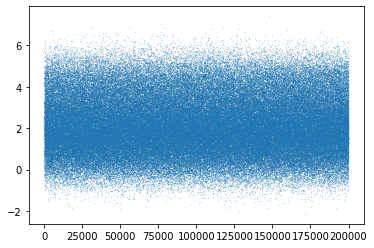

In [67]:
plt.scatter(np.arange(len(e)), e, s=0.01), torch.mean(e), torch.var(e)

In [114]:
model_inside.eval()
model_inside.backbone[0].block(torch.ones((1, 1, 117, 4)).to(device="cuda:0"))

tensor([[[[ 15.3043,  15.3043,  15.3043,  15.3043],
          [ 15.3043,  15.3043,  15.3043,  15.3043],
          [ 15.3043,  15.3043,  15.3043,  15.3043],
          ...,
          [ 15.3043,  15.3043,  15.3043,  15.3043],
          [ 15.3043,  15.3043,  15.3043,  15.3043],
          [ 15.3043,  15.3043,  15.3043,  15.3043]],

         [[ 11.9537,  11.9537,  11.9537,  11.9537],
          [ 11.9537,  11.9537,  11.9537,  11.9537],
          [ 11.9537,  11.9537,  11.9537,  11.9537],
          ...,
          [ 11.9537,  11.9537,  11.9537,  11.9537],
          [ 11.9537,  11.9537,  11.9537,  11.9537],
          [ 11.9537,  11.9537,  11.9537,  11.9537]],

         [[139.5148, 139.5148, 139.5148, 139.5148],
          [139.5148, 139.5148, 139.5148, 139.5148],
          [139.5148, 139.5148, 139.5148, 139.5148],
          ...,
          [139.5148, 139.5148, 139.5148, 139.5148],
          [139.5148, 139.5148, 139.5148, 139.5148],
          [139.5148, 139.5148, 139.5148, 139.5148]],

         ...,

In [115]:
model_inside.backbone[0](torch.ones((1, 1, 117, 4)).to(device="cuda:0"))

tensor([[[[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          ...,
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],

         [[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          ...,
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500]],

         [[0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500],
          [0.2500, 0.2500, 0.2500,  ..., 0

In [113]:
model_inside.backbone[0]

Sequential(
  (0): Conv2d(1, 64, kernel_size=(10, 1), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): PReLU(num_parameters=1)
  (3): Identity()
)

Text(0.5, 1.0, 'r2 = 0.29395, loss = 3.99339')

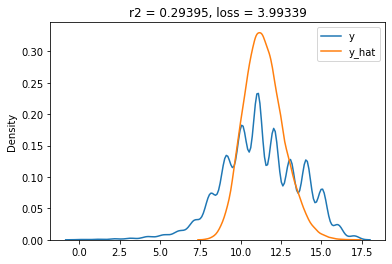

In [56]:
sns.kdeplot(ys)
sns.kdeplot(y_hats)

#e = torch.tensor(y_hats) - torch.tensor(ys)

metric = r2_score(torch.tensor(ys) + 0 * torch.rand_like(torch.tensor(ys)), y_hats)

loss = F.mse_loss(torch.tensor(ys) + 0 * torch.rand_like(torch.tensor(ys)), torch.tensor(y_hats))

#print(torch.stack((y, y_hats)).T)

plt.legend(['y', "y_hat"])

plt.title(f"r2 = {round(metric.item(), 5)}, loss = {round(loss.item(), 5)}")

Text(0.5, 1.0, 'r2 = 0.37365, loss = 3.5204')

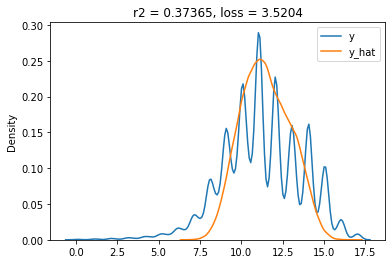

In [47]:
sns.kdeplot(ys)
sns.kdeplot(y_hats)

#e = torch.tensor(y_hats) - torch.tensor(ys)

metric = r2_score(torch.tensor(ys[:-1]) + 0 * torch.rand_like(torch.tensor(ys[:-1])), y_hats)

loss = F.mse_loss(torch.tensor(ys[:-1]) + 0 * torch.rand_like(torch.tensor(ys[:-1])), torch.tensor(y_hats))

#print(torch.stack((y, y_hats)).T)

plt.legend(['y', "y_hat"])

plt.title(f"r2 = {round(metric.item(), 5)}, loss = {round(loss.item(), 5)}")

In [ ]:
next(iter(dataloader_train))[2]

In [71]:
trainer.save_checkpoint("checkpoints/best_model.chpt")

(<matplotlib.collections.PathCollection at 0x150e4d5051f0>,
 tensor(1.0969),
 tensor(1.4104))

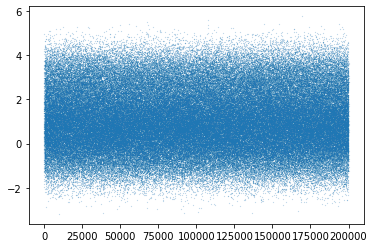

In [75]:
plt.scatter(np.arange(len(e)), e, s=0.01), e.mean(), e.std()

In [32]:
torch.stack((torch.tensor(y_hats), torch.tensor(ys))).T[:20]

tensor([[ 9.9820, 10.0547],
        [12.4601, 13.5234],
        [10.1582, 12.0859],
        [ 9.8183,  9.9453],
        [10.1663,  9.1250],
        [10.0216, 10.3984],
        [ 9.6821,  8.2812],
        [10.5161,  9.3828],
        [ 9.4106, 11.6875],
        [11.8258, 11.9609],
        [10.9126,  9.4141],
        [11.7920, 11.0781],
        [ 9.5310,  9.1562],
        [11.1239,  9.0703],
        [11.9120, 12.0781],
        [13.4912, 15.0312],
        [11.3543, 13.0234],
        [11.0506, 17.0000],
        [ 9.9491, 10.0938],
        [11.8480, 11.5859]])

In [99]:
features = nn.Sequential(*list(model_inside.model.children())[:-1])(X).squeeze()

AttributeError: 'SimpleConvNet' object has no attribute 'model'

In [359]:
np.corrcoef(features.cpu().detach().numpy()[:,0], y)

array([[1.        , 0.10192391],
       [0.10192391, 1.        ]])

In [360]:
corrs = abs(
    np.corrcoef(features.cpu().detach().numpy().T, y)[
    np.ix_(np.arange(256, dtype=np.int32), np.array([256]))].ravel()
)

<AxesSubplot:ylabel='Density'>

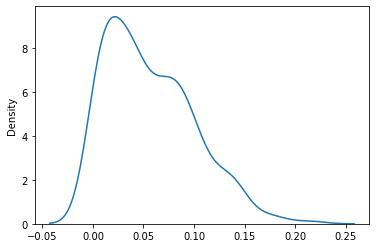

In [361]:
sns.kdeplot(corrs)